In [1]:
import os
import yaml
from pprint import pprint

import pandas as pd

upDir = lambda path : os.path.join('..', path)

#class Data:
#    def __init__(self, data):
#        assert isinstance(data, dict)
#        self.__dict__ = {**self.__dict__, **data}
        

class Config:
    def __init__(self, path=None, data=None):
        if path is not None:
            with open(path) as f:
                data = yaml.full_load(f)
        assert data is not None
        self.__dict__ = {**self.__dict__, **data}
    def __repr__(self):
        return yaml.dump(self.__dict__)
                            
    
config = Config('../config.yml')

In [2]:
picklist = pd.read_csv(upDir(config.echo['picklist'][0]),
                      index_col=0)
plate_names = dict(zip(picklist['Destination Plate Name'].unique(),
                       [f'plate_{i}' for i in range(1,16)]))

picklist['dest_plate'] = [plate_names[i] for i in picklist['Destination Plate Name']]
picklist

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl,dest_plate
0,src racks 0..4,S1005,A1,dest racks 0..4 0,A1,20.0,plate_1
1,src racks 0..4,S1005,A1,dest racks 0..4 0,A2,212.5,plate_1
2,src racks 0..4,S1005,A1,dest racks 0..4 0,A3,605.0,plate_1
3,src racks 0..4,S1005,A1,dest racks 0..4 0,A4,1202.5,plate_1
4,src racks 0..4,S1005,A1,dest racks 0..4 0,A5,2000.0,plate_1
...,...,...,...,...,...,...,...
4105,src racks 8..12,S4401,P21,dest racks 8..12 4,B19,20.0,plate_15
4106,src racks 8..12,S4401,P21,dest racks 8..12 4,B20,212.5,plate_15
4107,src racks 8..12,S4401,P21,dest racks 8..12 4,B21,605.0,plate_15
4108,src racks 8..12,S4401,P21,dest racks 8..12 4,B22,1202.5,plate_15


In [3]:
_exceptions = [i for i in  config.echo['transfers'] if 'Exceptions' in i]
assert len(_exceptions) == 1
_exceptions = _exceptions[0]

exceptions = pd.read_csv(upDir(_exceptions))
src_plate_names = dict(zip(sorted(exceptions['Source Plate Name'].unique()),
                           sorted(picklist['SrcPlate'].unique()),
                          ))
dest_plate_names = dict(zip([f'Destination[{i}]' for i in range(2,17)],
                             sorted(picklist['Destination Plate Name'].unique()),
                           ))

exceptions['src_plate'] = [src_plate_names[i] for i in exceptions['Source Plate Name']]
exceptions['dest_plate'] = [dest_plate_names[i] for i in exceptions['Destination Plate Name']]
print(f'number of exceptions: {len(exceptions)}')
exceptions.head()

number of exceptions: 211


,Source Plate Name,Source Plate Barcode,Source Plate Type,Source Well,Destination Plate Name,Destination Plate Barcode,Destination Plate Type,Destination Well,Destination Well X Offset,Destination Well Y Offset,...,Sample Name,Transfer Volume,Actual Volume,Current Fluid Volume,Fluid Composition,Fluid Units,Fluid Type,Transfer Status,src_plate,dest_plate
0,Source[2],NaN,384LDV_DMSO,M1,Destination[2],NaN,384PP_Dest,B15,0,0,...,NaN,605.0,300,1.309,71.324,Percent,DMSO,MM0202006: Problem calc. eo fc: 1.82577 ft: 0....,src racks 0..4,dest racks 0..4 0
1,Source[2],NaN,384LDV_DMSO,M1,Destination[2],NaN,384PP_Dest,B14,0,0,...,NaN,212.5,0,1.309,71.324,Percent,DMSO,MM0202006: Problem calc. eo fc: 1.82577 ft: 0....,src racks 0..4,dest racks 0..4 0
2,Source[2],NaN,384LDV_DMSO,M1,Destination[2],NaN,384PP_Dest,B13,0,0,...,NaN,20.0,0,1.309,71.324,Percent,DMSO,MM0202006: Problem calc. eo fc: 1.82577 ft: 0....,src racks 0..4,dest racks 0..4 0
3,Source[2],NaN,384LDV_DMSO,C3,Destination[2],NaN,384PP_Dest,C11,0,0,...,NaN,2000.0,0,0.000,0.000,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...,src racks 0..4,dest racks 0..4 0
4,Source[2],NaN,384LDV_DMSO,C3,Destination[2],NaN,384PP_Dest,C10,0,0,...,NaN,1202.5,0,0.000,0.000,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...,src racks 0..4,dest racks 0..4 0


In [4]:
def get_actual_vol(src_plate_name, 
                   dest_plate_name, 
                   well, 
                   vol):
    chunk = exceptions.loc[exceptions['src_plate'] == src_plate_name, :]
    chunk = chunk.loc[chunk['dest_plate'] == well, :]
    row = chunk.loc[chunk['Destination Well'] == well, :]
    if len(row) > 0:
        actual_vol = row['Actual Volume']
        return actual_vol
    if len(row) > 1:
        pass
    else:
        return vol
                    
a = [get_actual_vol(i,j,k,l) for i,j,k,l in zip(picklist['SrcPlate'],
                                                picklist['Destination Plate Name'],
                                                picklist['DestWell'],
                                                picklist['Transfer Volume /nl'])]
picklist['actual_vol'] = a
picklist.head()

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl,dest_plate,actual_vol
0,src racks 0..4,S1005,A1,dest racks 0..4 0,A1,20.0,plate_1,20.0
1,src racks 0..4,S1005,A1,dest racks 0..4 0,A2,212.5,plate_1,212.5
2,src racks 0..4,S1005,A1,dest racks 0..4 0,A3,605.0,plate_1,605.0
3,src racks 0..4,S1005,A1,dest racks 0..4 0,A4,1202.5,plate_1,1202.5
4,src racks 0..4,S1005,A1,dest racks 0..4 0,A5,2000.0,plate_1,2000.0


In [5]:
pwd

'/home/james/thesis-stuff/screening-fist/lab/01.0/nb'

In [6]:
import copy

from sxfst.utils import PlateData

plates = copy.deepcopy(config.platereader)
for i in plates:
    plates[i]['picklist'] = picklist.loc[picklist['dest_plate'] == i, :]
    plates[i]['test']['data'] = PlateData(upDir(plates[i]['test']['path']))
    plates[i]['control']['data'] = PlateData(upDir(plates[i]['control']['path']))
    
pprint(plates['plate_1'])

{'control': {'data': .././platereader/22042022,131152_220425103858.CSV
User: USER,Path: C:\Program Files (x86)\BMG\CLARIOstar\User\Data\,Test run no.: 2870

 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
A :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
B :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
C :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
D :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
E :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
F :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
G :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
H :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
I :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
J :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
K :  :  :  :  :  :  :  :  :  :

In [7]:
from tqdm import tqdm                                                      
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

def plot_set(*data, 
             labels=None,
             vols=None,
             title=''):                                                 
    assert len(data) > 0, 'empty set given'                                   
    if len(data) < 8:                                                         
        fig, ax = plt.subplots(1, 
                               len(data),                                     
                               figsize=(3*len(data),3))                                 
    else:                                                                      
        fig, ax = plt.subplots(len(data)//(nRows:=8),                         
                               nRows,                                          
                               figsize=(16,128*(len(data) / len(data))))     
                                                                               
    for wells, ax_ in zip(data, ax.flatten()):                                  
        if vols is None:
            vols = range(len(wells))
        for row_, vol in zip(wells.index, vols):                                 
            ax_.plot(wells.loc[row_,:], 
                     c=plt.cm.cool(vol/2000),
                     label=vol)
                                                                               
        ax_.set_xlim(280,800)                                                  
        ax_.set_ylim(-0.02,0.2)                                                  
        ax_.set_title(title)                                                     
        ax_.set_xlabel('Wavelength (nm)')                                      
        ax_.axis('off')                                                        
        ax_.legend()
                                                                               
    plt.title(title)                                                           
    plt.tight_layout()                     
    plt.show()
    
#plot_set(test_wells, 
#         ctrl_wells, 
#         test_wells - ctrl_wells,
#         vols=pck_1['actual_vol'])

In [8]:
from scipy.ndimage import gaussian_filter1d

def norm_traces(test, 
                ctrl=None):
    test = test.subtract(test.loc[:,800],
                         axis=0)
    if ctrl is not None:
        ctrl = ctrl.subtract(ctrl.loc[:,800],
                             axis=0)
        norm = test - ctrl
        return norm
    else:
        return test

def smooth(df,
           sigma=3,
           ):
    cols = df.columns
    idx = df.index
    smth = pd.DataFrame(gaussian_filter1d(df, sigma),
                        index=idx,
                        columns=cols)
    return df

def is_anomaly(norm):
    return False

def diff(norm, baseline):
    return norm.subtract(baseline,
                         axis=0)

def response(_diff):
    a420 = _diff.loc[:,420]
    a390 = _diff.loc[:,390]
    return a420.abs().add(a390.abs())

def c2(v1, c1, v2):
    return (v1 * c1) / v2

def proc(cpd, # Cpd()
         sigma=3,
         ):
    name = cpd.name
    test = cpd.test
    ctrl = cpd.ctrl
    echo_map = cpd.echo_map
    norm = norm_traces(test, ctrl)
    smth = smooth(norm, sigma)
    if not is_anomaly(smth):
        change = diff(smth, smth[list(smth.keys())[0]])
        y = dict(response(change))
        #print(y)
        vol_well_map = dict(zip(echo_map['DestWell'],
                                echo_map['Transfer Volume /nl']))
        x = {i:c2(v1=vol_well_map[i] * 1e-9,    # nl to l
                  c1=10e-3,                     # 10 mM stock
                  v2=40e-6,                     # 40 ul well vol
                  ) / 1e-6                     # M to uM
              for i in vol_well_map}
        print(x)
        print(y)


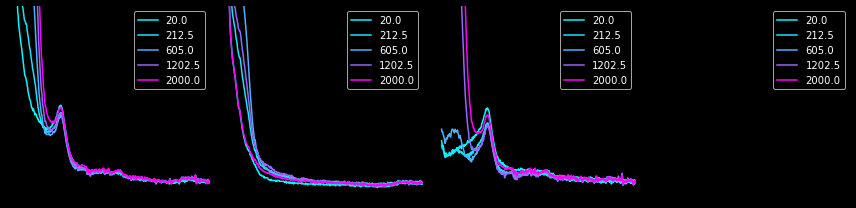

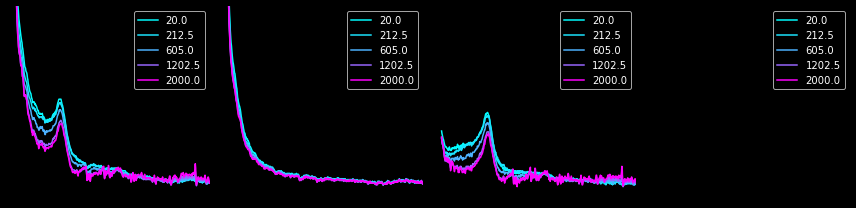

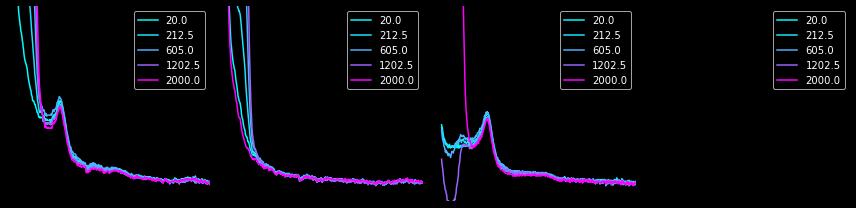

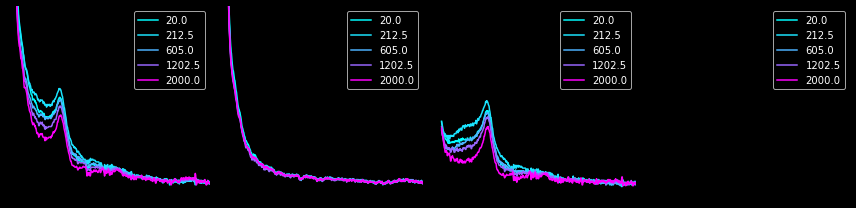

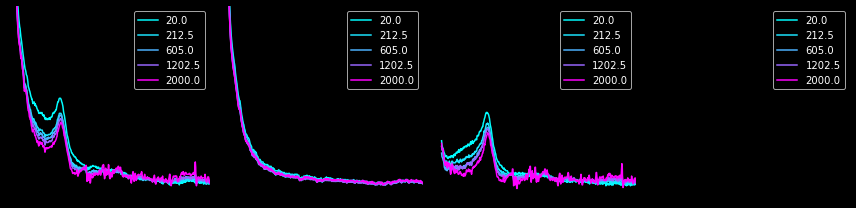

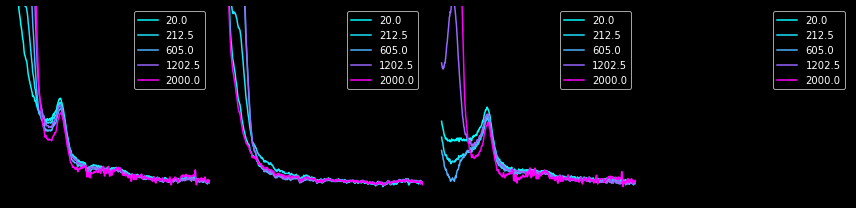

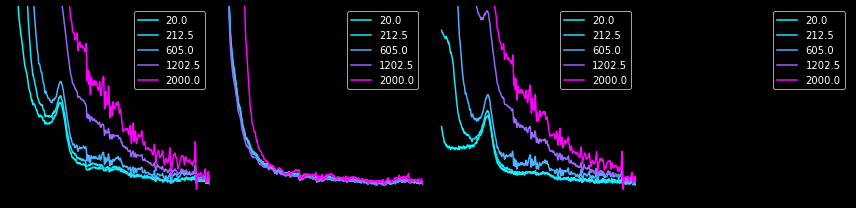

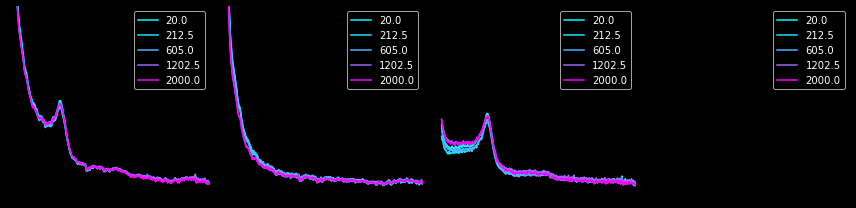

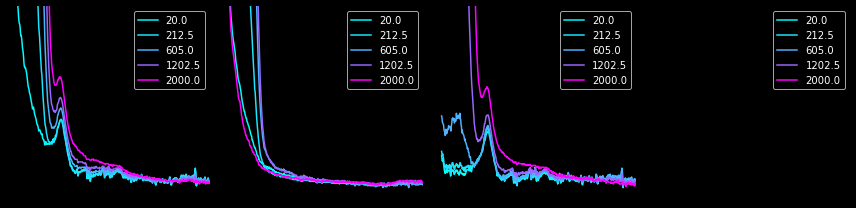

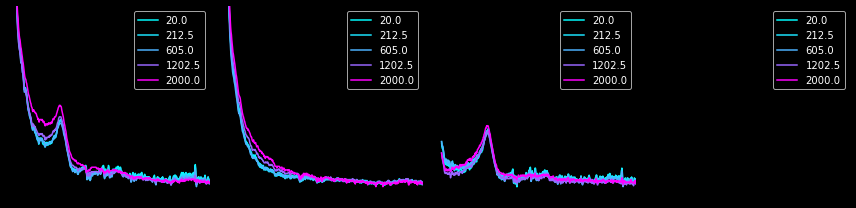

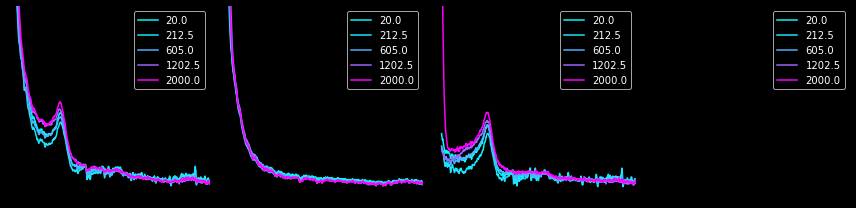

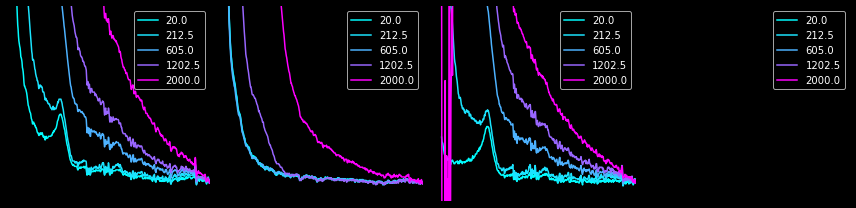

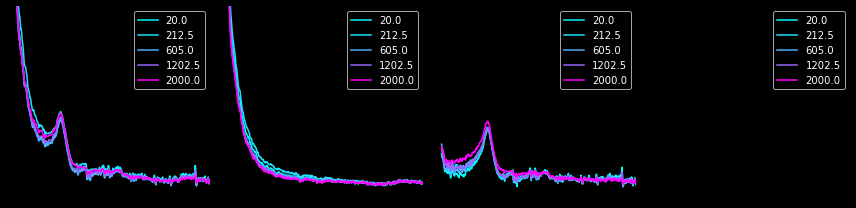

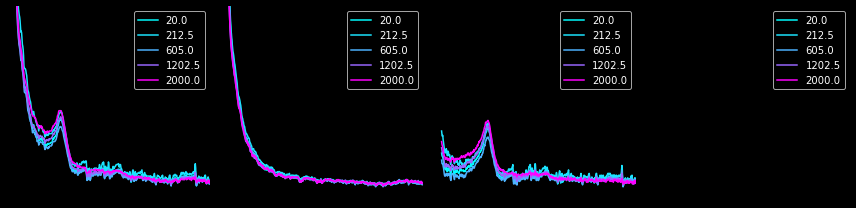

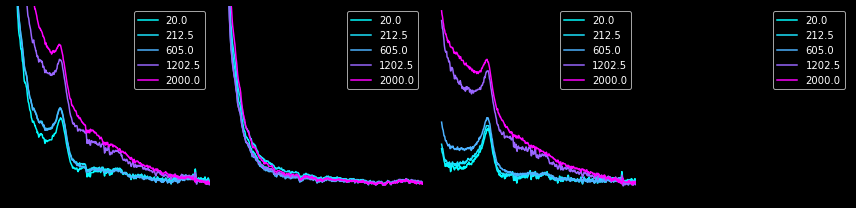

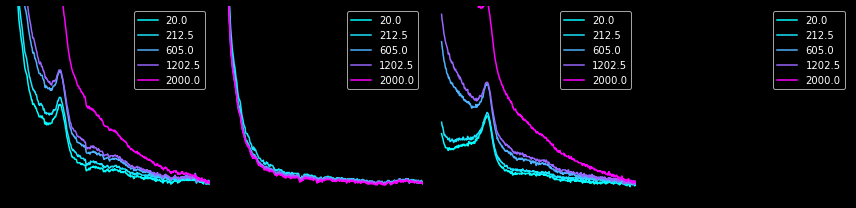

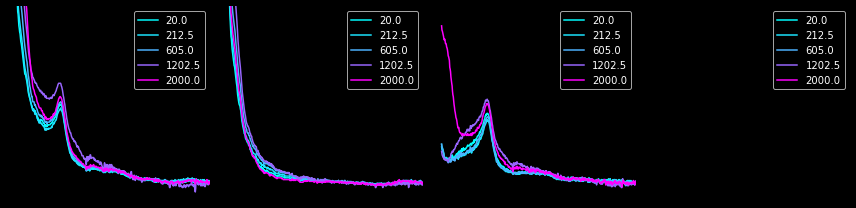

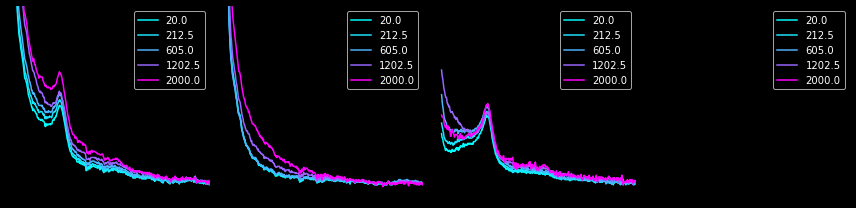

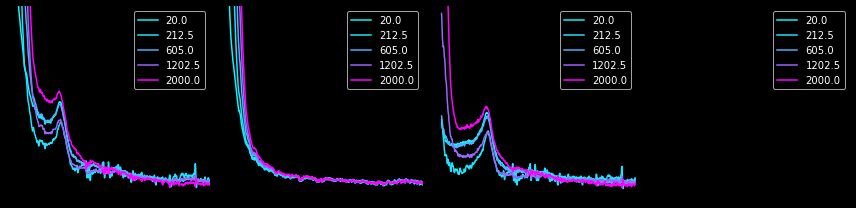

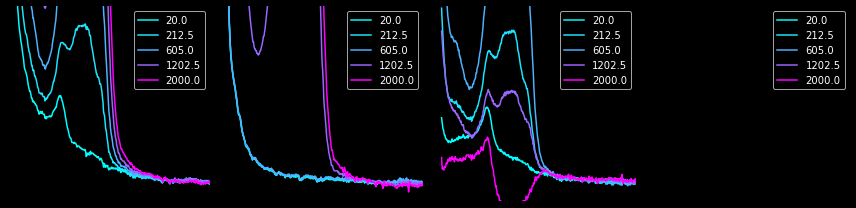

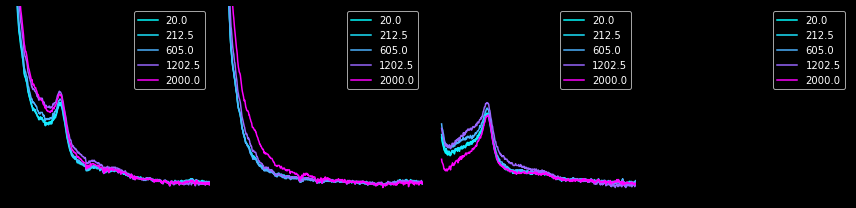

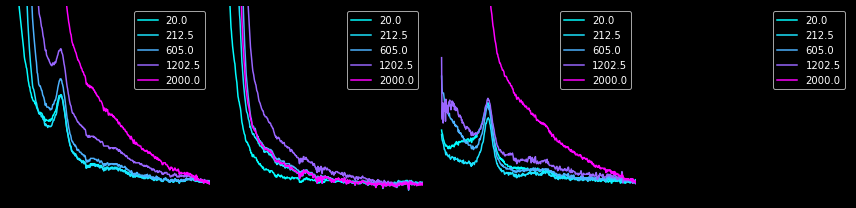

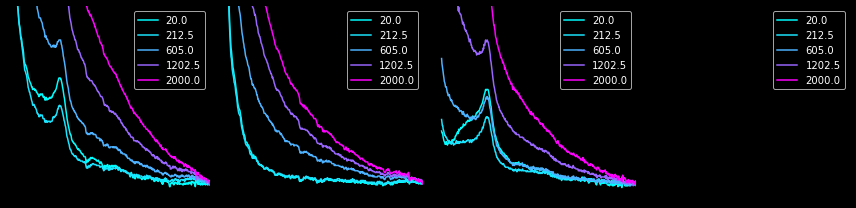

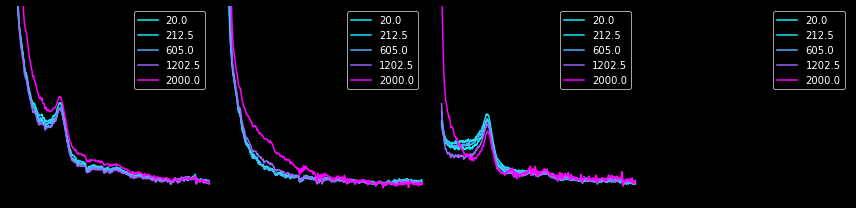

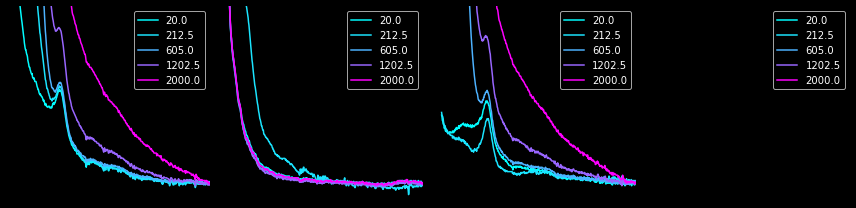

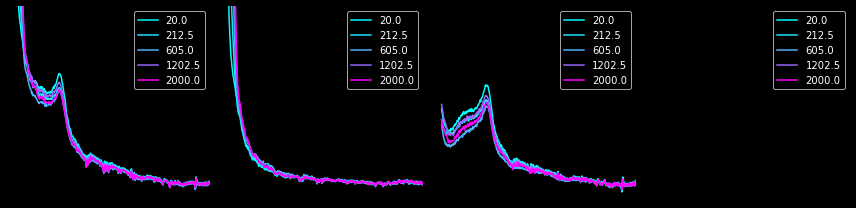

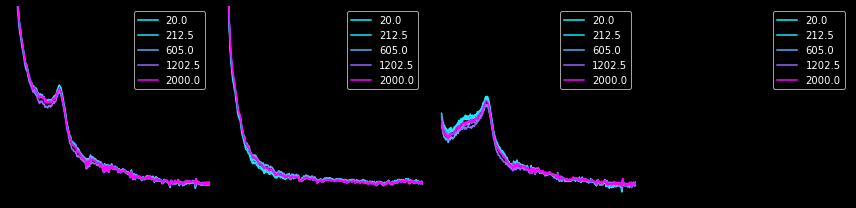

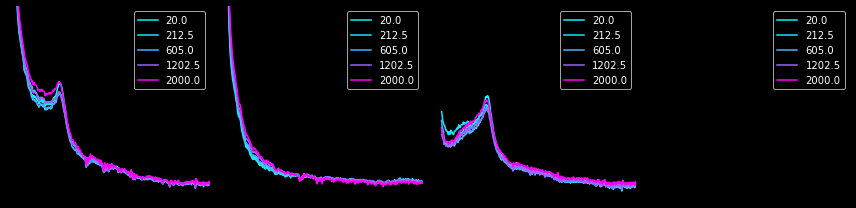

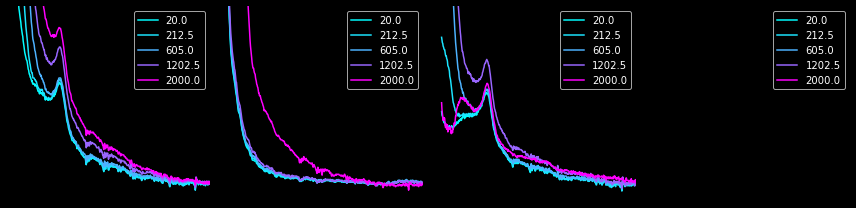

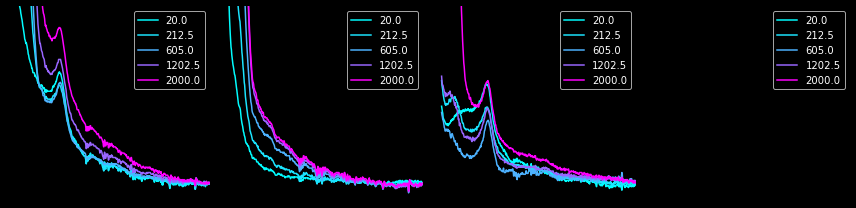

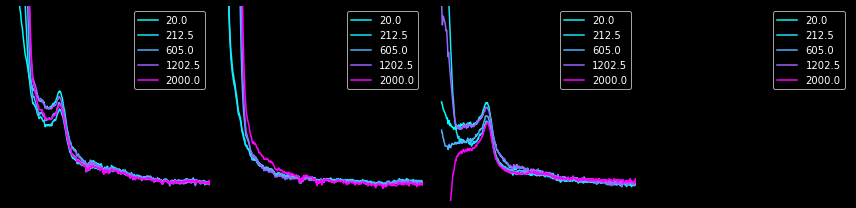

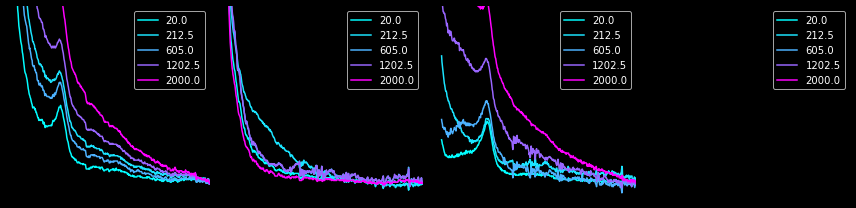

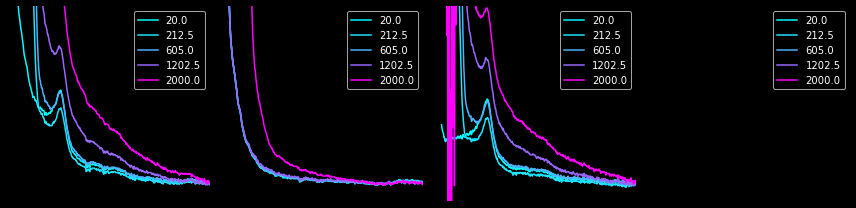

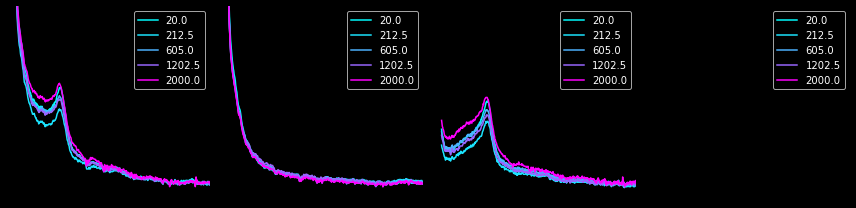

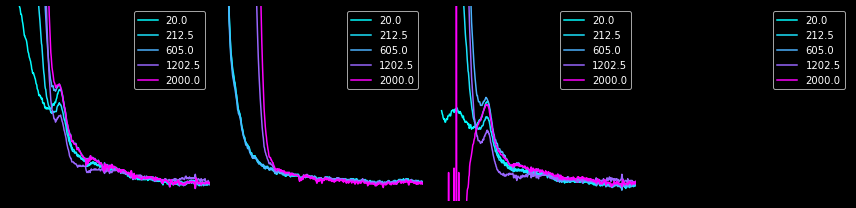

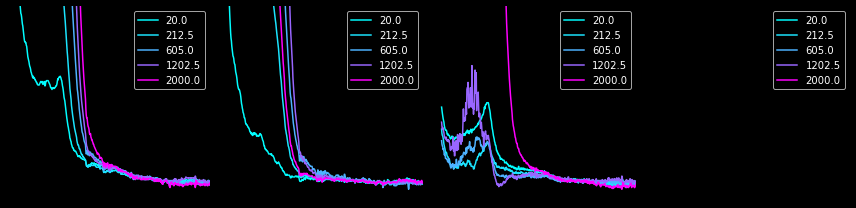

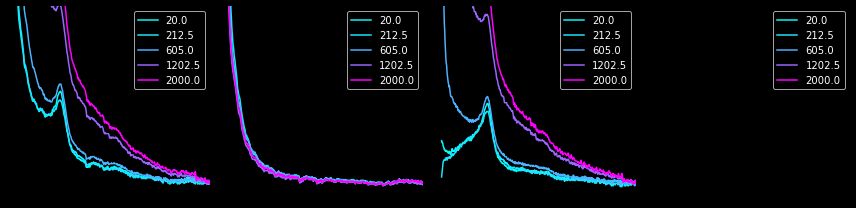

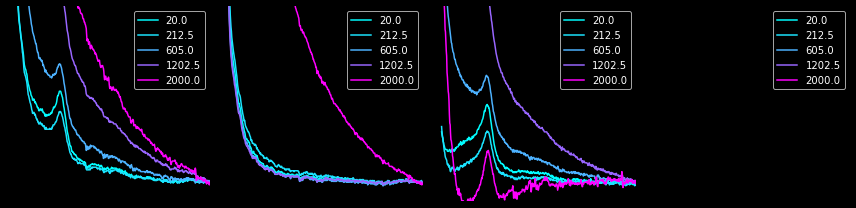

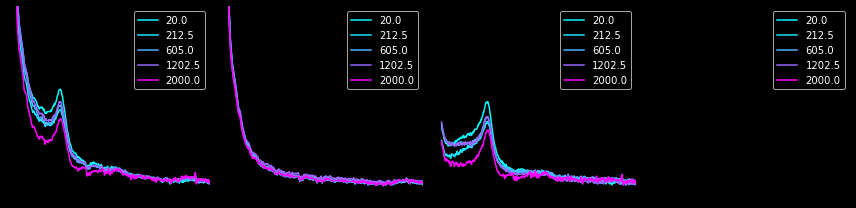

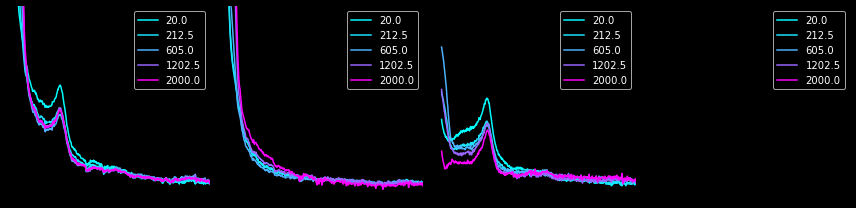

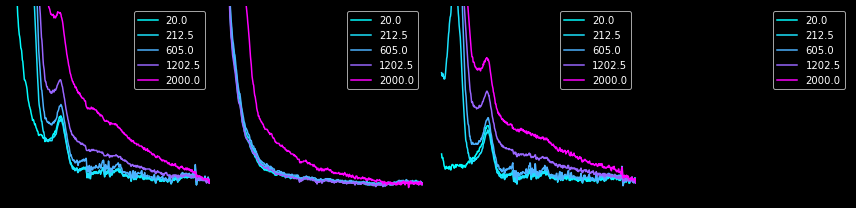

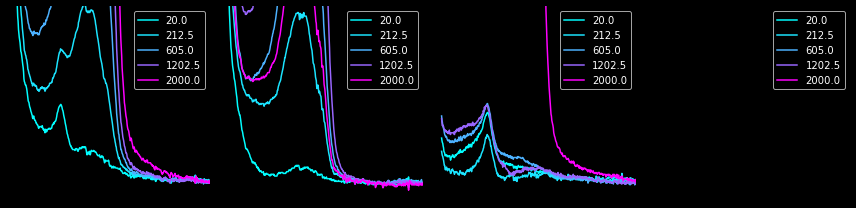

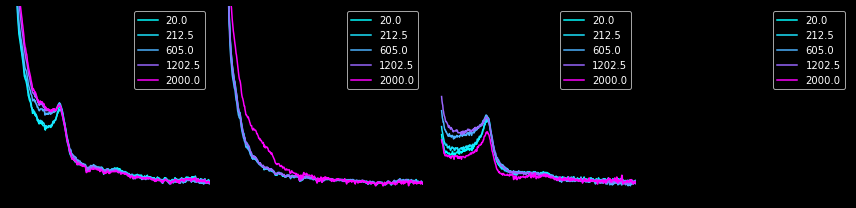

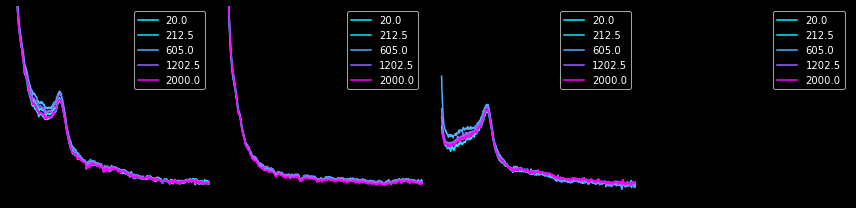

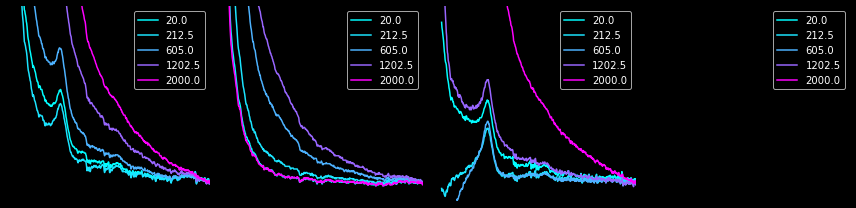

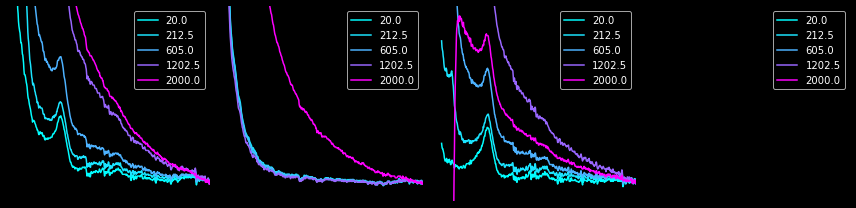

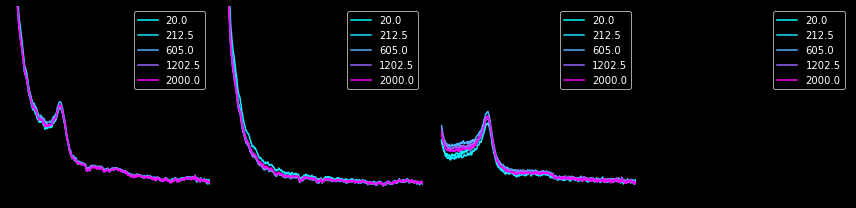

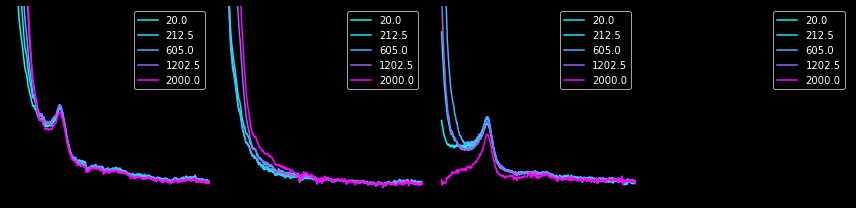

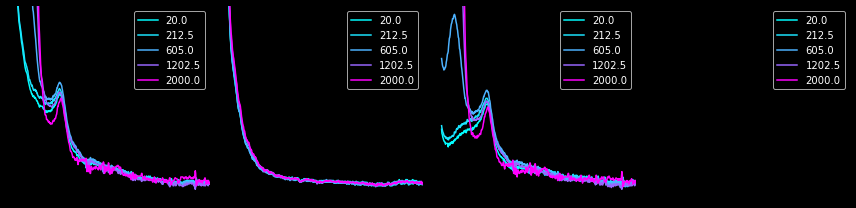

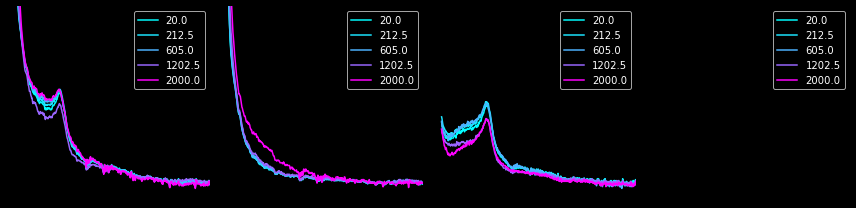

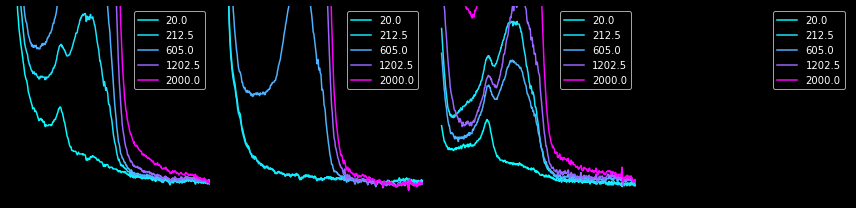

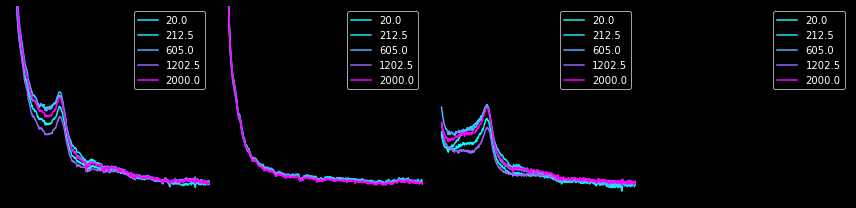

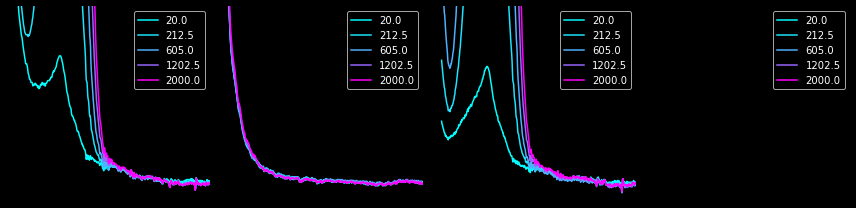

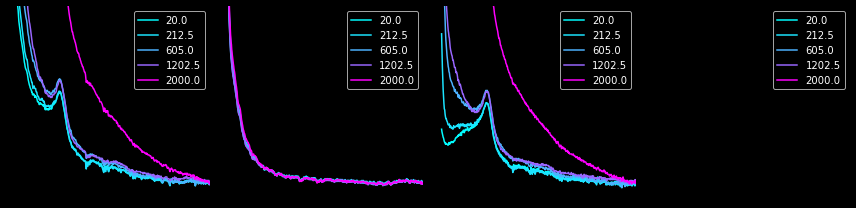

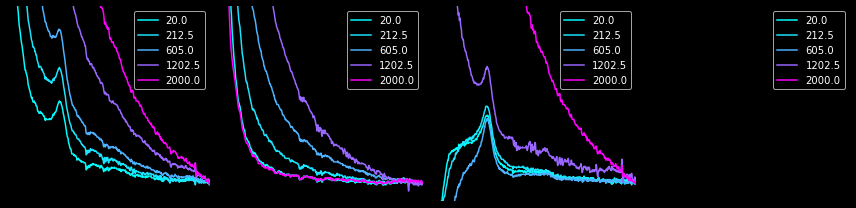

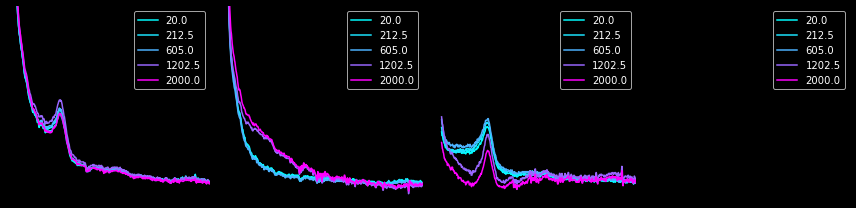

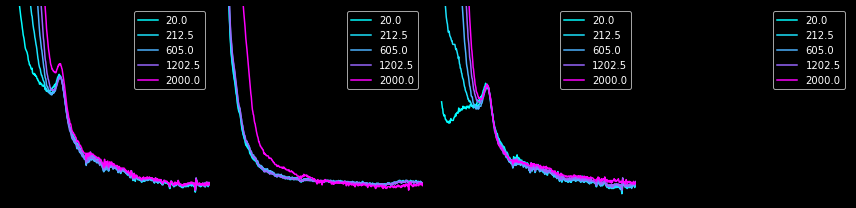

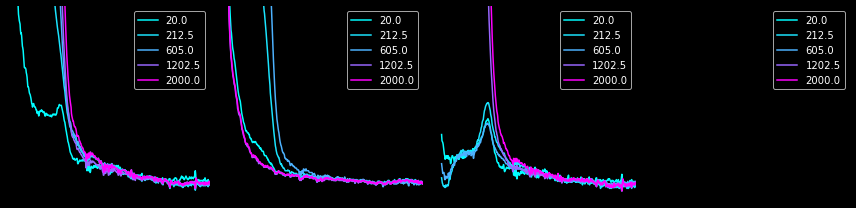

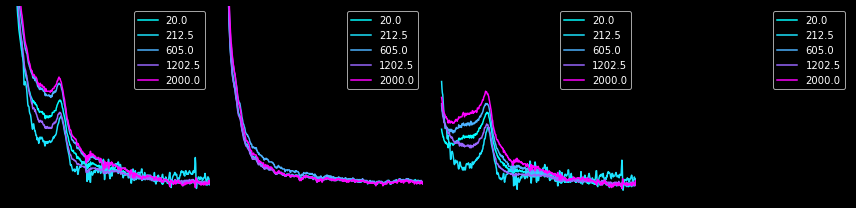

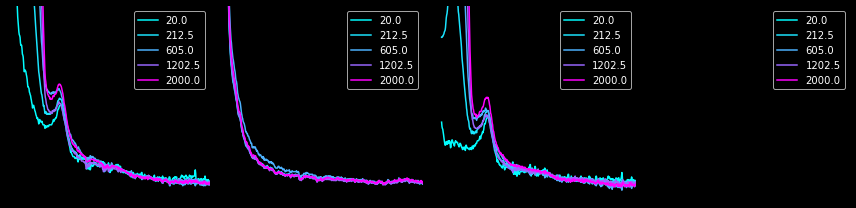

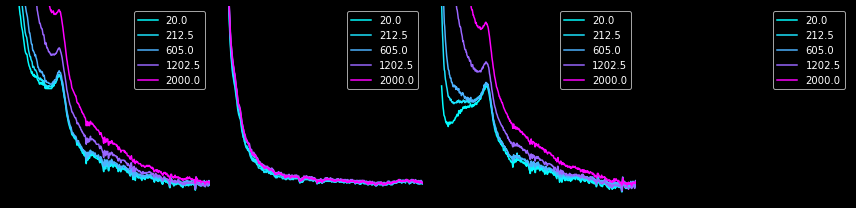

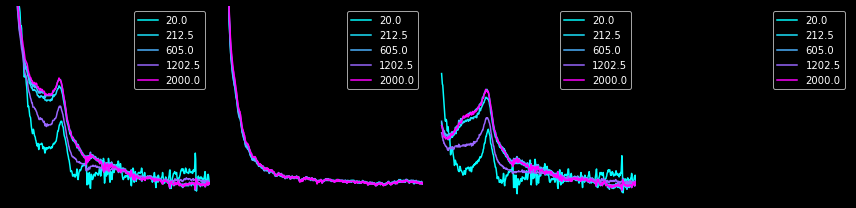

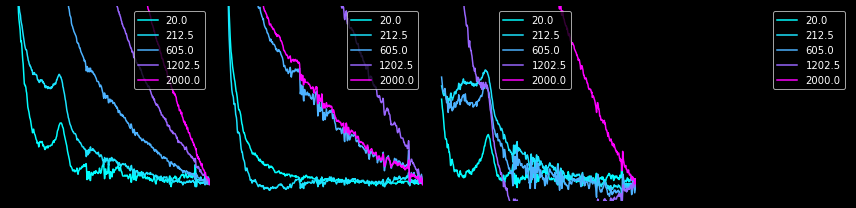

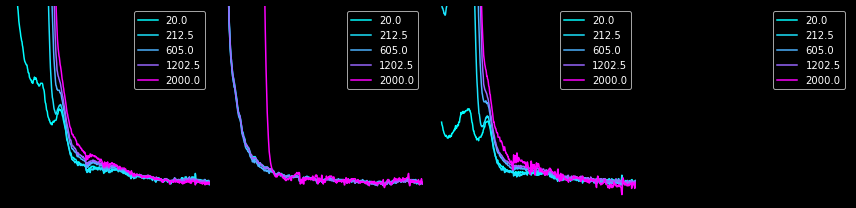

In [9]:
from sxfst.utils import plotTraces

plate_1 = plates['plate_1']
pck_1 = plate_1['picklist']
prot_only = [i for i in plate_1['control']['data'].df.index \
             if i not in pck_1['DestWell'].to_list()]

sigma = 8

for i in pck_1['Cpd'].unique():
    pck_chunk = pck_1.loc[pck_1['Cpd'] == i, :]
    test_wells = norm_traces(smooth(plate_1['test']['data'][pck_chunk['DestWell'].to_list()], 
                                    sigma=sigma))
    ctrl_wells = norm_traces(smooth(plate_1['control']['data'][pck_chunk['DestWell'].to_list()], 
                                    sigma=sigma))
    plate_row = set([i[0] for i in test_wells.index.to_list() + ctrl_wells.index.to_list()])
    assert len(plate_row) == 1
    plate_row = list(plate_row)[0]
    _prots =  [i for i in prot_only if plate_row in i]
    prots = norm_traces(smooth(plate_1['test']['data'][_prots], 
                               sigma=sigma))
    plot_set(test_wells, 
             ctrl_wells, 
             test_wells - ctrl_wells,
             diff(test_wells, prots.mean(axis=0)),
             vols=pck_chunk['actual_vol'])

In [10]:
response(test_wells)

J19    0.149
J20    0.228
J21    0.435
J22    0.756
J23    1.173
dtype: float64

In [11]:
test_wells

,300,301,302,303,304,305,306,307,308,309,...,791,792,793,794,795,796,797,798,799,800
J19,0.293,0.270,0.253,0.239,0.227,0.217,0.207,0.199,0.195,0.188,...,0.002,0.001,0.003,0.001,0.001,0.002,0.002,0.002,0.000,0.0
J20,0.422,0.399,0.381,0.369,0.357,0.347,0.337,0.330,0.326,0.320,...,0.001,0.000,0.001,0.001,0.002,0.003,0.001,0.000,-0.002,0.0
J21,0.675,0.654,0.639,0.627,0.618,0.613,0.607,0.603,0.602,0.601,...,0.001,0.000,0.001,0.000,0.001,0.002,0.003,0.003,0.000,0.0
J22,1.070,1.053,1.038,1.029,1.025,1.021,1.019,1.020,1.022,1.023,...,0.001,0.001,0.000,0.000,0.001,0.001,0.002,0.001,0.000,0.0
J23,1.537,1.520,1.508,1.500,1.500,1.510,1.515,1.515,1.511,1.513,...,-0.001,-0.001,0.001,-0.001,-0.001,-0.001,0.000,0.001,-0.001,0.0
